# Terms of Use

### Please solve the authorization problem of the dataset on your own. You shall be solely responsible for any problems caused by the use of non-authorized datasets for training and all consequences thereof.The repository and its maintainer, svc develop team, have nothing to do with the consequences!

1. This project is established for academic exchange purposes only and is intended for communication and learning purposes. It is not intended for production environments.
2. Any videos based on sovits that are published on video platforms must clearly indicate in the description that they are used for voice changing and specify the input source of the voice or audio, for example, using videos or audios published by others and separating the vocals as input source for conversion, which must provide clear original video or music links. If your own voice or other synthesized voices from other commercial vocal synthesis software are used as the input source for conversion, you must also explain it in the description.
3. You shall be solely responsible for any infringement problems caused by the input source. When using other commercial vocal synthesis software as input source, please ensure that you comply with the terms of use of the software. Note that many vocal synthesis engines clearly state in their terms of use that they cannot be used for input source conversion.
4. Continuing to use this project is deemed as agreeing to the relevant provisions stated in this repository README. This repository README has the obligation to persuade, and is not responsible for any subsequent problems that may arise.
5. If you distribute this repository's code or publish any results produced by this project publicly (including but not limited to video sharing platforms), please indicate the original author and code source (this repository).
6. If you use this project for any other plan, please contact and inform the author of this repository in advance. Thank you very much.


## **Note:**
## **Make sure there is no a directory named `sovits4data` in your google drive at the first time you use this notebook.**
## **It will be created to store some necessary files.** 
## **For sure you can change it to another directory by modifying `sovits_data_dir` variable.**

# **Initialize environment**

In [ ]:
#@title Connect to colab runtime and check GPU

#@markdown # Connect to colab runtime and check GPU

#@markdown

!nvidia-smi

In [ ]:
#@title Clone repository and install requirements

#@markdown # Clone repository and install requirements

#@markdown

#@markdown ### After the execution is completed, the runtime will **automatically restart**

#@markdown

!git clone https://github.com/svc-develop-team/so-vits-svc -b 4.0
!pip uninstall torchdata torchtext
!pip install --upgrade pip setuptools numpy numba
!pip install pyworld praat-parselmouth fairseq tensorboardX torchcrepe librosa==0.9.1
!pip install torch==1.13.1+cu117 torchvision==0.14.1+cu117 torchaudio==0.13.1+cu117 --extra-index-url https://download.pytorch.org/whl/cu117
%cd /content/so-vits-svc
!curl -L https://github.com/openvpi/vocoders/releases/download/nsf-hifigan-v1/nsf_hifigan_20221211.zip -o /content/so-vits-svc/nsf_hifigan_20221211.zip
!unzip nsf_hifigan_20221211.zip
!rm -rf pretrain/nsf_hifigan
!mv -v nsf_hifigan pretrain
!curl -L https://ibm.ent.box.com/shared/static/z1wgl1stco8ffooyatzdwsqn2psd9lrr -o /content/so-vits-svc/hubert/checkpoint_best_legacy_500.pt
exit()

In [ ]:
#@title Mount google drive and select which directories to sync with google drive

#@markdown # Mount google drive and select which directories to sync with google drive

#@markdown

from google.colab import drive
drive.mount("/content/drive")

#@markdown Directory to store **necessary files**, dont miss the slash at the end👇.
sovits_data_dir = "/content/drive/MyDrive/sovits4data/"  #@param {type:"string"}
#@markdown By default it will create a `sovits4data/` folder in your google drive.
RAW_DIR = sovits_data_dir + "raw/"
RESULTS_DIR = sovits_data_dir + "results/"
FILELISTS_DIR = sovits_data_dir + "filelists/"
CONFIGS_DIR = sovits_data_dir + "configs/"
LOGS_DIR = sovits_data_dir + "logs/44k/"

#@markdown

#@markdown ### These folders will be synced with your google drvie

#@markdown　### **Strongly recommend to check all.**

#@markdown Sync **input audios** and **output audios**
sync_raw_and_results = True  #@param {type:"boolean"}
if sync_raw_and_results:
  !mkdir -p {RAW_DIR}
  !mkdir -p {RESULTS_DIR}
  !rm -rf /content/so-vits-svc/raw
  !rm -rf /content/so-vits-svc/results
  !ln -s {RAW_DIR} /content/so-vits-svc/raw
  !ln -s {RESULTS_DIR} /content/so-vits-svc/results

#@markdown Sync **config** and **models**
sync_configs_and_logs = True  #@param {type:"boolean"}
if sync_configs_and_logs:
  !mkdir -p {FILELISTS_DIR}
  !mkdir -p {CONFIGS_DIR}
  !mkdir -p {LOGS_DIR}
  !rm -rf /content/so-vits-svc/filelists
  !rm -rf /content/so-vits-svc/configs
  !rm -rf /content/so-vits-svc/logs/44k
  !ln -s {FILELISTS_DIR} /content/so-vits-svc/filelists
  !ln -s {CONFIGS_DIR} /content/so-vits-svc/configs
  !ln -s {LOGS_DIR} /content/so-vits-svc/logs/44k

In [ ]:
#@title Get pretrained model(Optional but strongly recommend).

#@markdown # Get pretrained model(Optional but strongly recommend).

#@markdown

#@markdown - Pre-trained model files: `G_0.pth` `D_0.pth`
#@markdown   - Place them under /sovits4data/logs/44k/ in your google drive manualy

#@markdown Get them from svc-develop-team(TBD) or anywhere else.

#@markdown Although the pretrained model generally does not cause any copyright problems, please pay attention to it. For example, ask the author in advance, or the author has indicated the feasible use in the description clearly.

!pwd

# **Dataset preprocessing**

Pack and upload your raw dataset(dataset_raw/) to your google drive.

Makesure the file structure in your zip file looks like this:

```
YourZIPforSingleSpeakers.zip
└───speaker
    ├───xxx1-xxx1.wav
    ├───...
    └───Lxx-0xx8.wav
```

```
YourZIPforMultipleSpeakers.zip
├───speaker0
│   ├───xxx1-xxx1.wav
│   ├───...
│   └───Lxx-0xx8.wav
└───speaker1
    ├───xx2-0xxx2.wav
    ├───...
    └───xxx7-xxx007.wav
```

**Even if there is only one speaker, a folder named `{speaker_name}` is needed.**

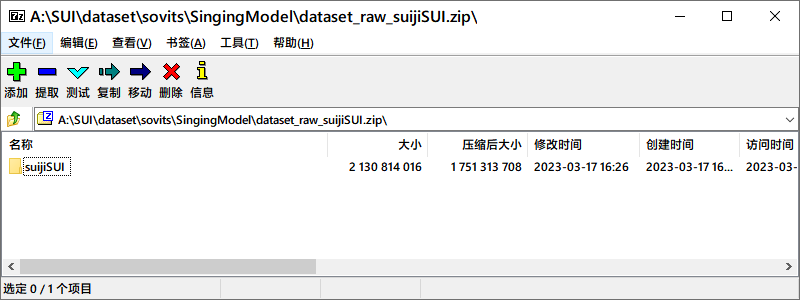

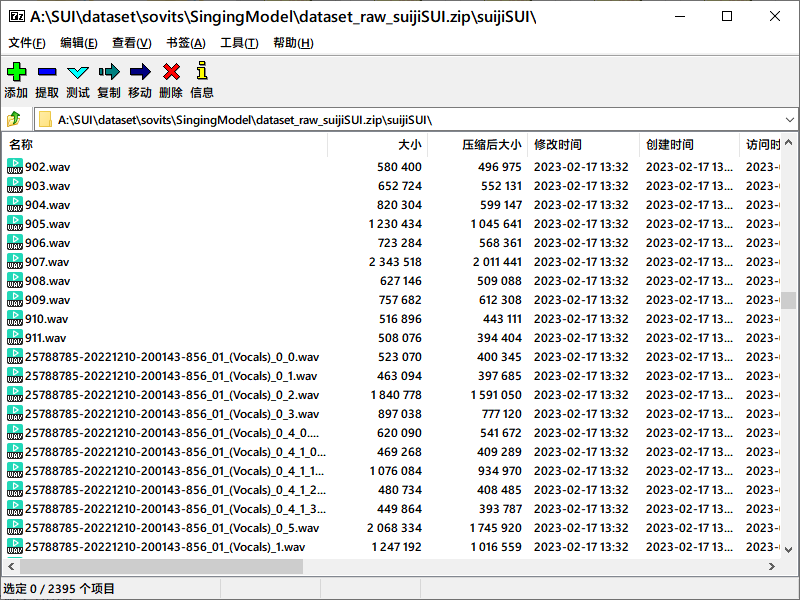

In [ ]:
#@title Get raw dataset from google drive

#@markdown # Get raw dataset from google drive

#@markdown

#@markdown Directory where **your zip file** located in, dont miss the slash at the end👇.
sovits_data_dir = "/content/drive/MyDrive/sovits4data/"  #@param {type:"string"}
#@markdown Filename of **your zip file**, do NOT be "dataset.zip"
zip_filename = "YourZIPFilenameofRawDataset.zip"  #@param {type:"string"}
ZIP_PATH = sovits_data_dir + zip_filename

!unzip -od /content/so-vits-svc/dataset_raw {ZIP_PATH}

In [ ]:
#@title Resample to 44100Hz and mono

#@markdown # Resample to 44100Hz and mono

#@markdown

%cd /content/so-vits-svc
!python resample.py

In [ ]:
#@title Divide filelists and generate config.json

#@markdown # Divide filelists and generate config.json

#@markdown

%cd /content/so-vits-svc
!python preprocess_flist_config.py

In [ ]:
#@title Generate hubert and f0

#@markdown # Generate hubert and f0

#@markdown

%cd /content/so-vits-svc
!python preprocess_hubert_f0.py

In [ ]:
#@title Save the preprocessed dataset to google drive

#@markdown # Save the preprocessed dataset to google drive

#@markdown

#@markdown You can save the dataset and related files to your google drive for the next training

#@markdown **Directory for saving**, dont miss the slash at the end👇.
sovits_data_dir = "/content/drive/MyDrive/sovits4data/" #@param {type:"string"}

#@markdown There will be a `dataset.zip` contained `dataset/` in your google drive, which is preprocessed data.

!mkdir -p {sovits_data_dir}
!zip -r dataset.zip /content/so-vits-svc/dataset
!cp -vr dataset.zip "{sovits_data_dir}"

In [ ]:
#@title Unzip preprocessed dataset from google drive directly if you have preprocessed already.

#@markdown # Unzip preprocessed dataset from google drive directly if you have preprocessed already.

#@markdown

#@markdown Directory where **your preprocessed dataset** located in, dont miss the slash at the end👇.
sovits_data_dir = "/content/drive/MyDrive/sovits4data/" #@param {type:"string"}
CONFIG = sovits_data_dir + "configs/"
FILELISTS = sovits_data_dir + "filelists/"
DATASET = sovits_data_dir + "dataset.zip"

!cp -vr {CONFIG} /content/so-vits-svc/
!cp -vr {FILELISTS} /content/so-vits-svc/
!unzip {DATASET} -d /

# **Trainning**

In [ ]:
#@title Start training

#@markdown # Start training

#@markdown If you want to use pre-trained models, upload them to /sovits4data/logs/44k/ in your google drive manualy.

#@markdown

#@markdown Whether to enable tensorboard
tensorboard_on = True  #@param {type:"boolean"}

if tensorboard_on:
  %load_ext tensorboard
  %tensorboard --logdir logs/44k

%cd /content/so-vits-svc
!python train.py -c configs/config.json -m 44k

In [ ]:
#@title Train cluster model (Optional)

#@markdown # Train cluster model (Optional)

#@markdown #### Details see [README.md#cluster-based-timbre-leakage-control](https://github.com/svc-develop-team/so-vits-svc#cluster-based-timbre-leakage-control)

#@markdown

%cd /content/so-vits-svc
!python cluster/train_cluster.py

# **Inference**
### Upload wav files from this notebook
### **OR**
### Upload to `sovits4data/raw/` in your google drive manualy (should be faster)

In [ ]:
#@title Upload wav files, the filename should not contain any special symbols like `#` `$` `(` `)`

#@markdown # Upload wav files, the filename should not contain any special symbols like `#` `$` `(` `)`

#@markdown

%cd /content/so-vits-svc
%run wav_upload.py --type audio

Saving YourWAVFile.wav to YourWAVFile.wav


In [ ]:
#@title Start inference (and download)

#@markdown # Start inference (and download)

#@markdown Parameters see [README.MD#Inference](https://github.com/svc-develop-team/so-vits-svc#-inference)

#@markdown

wav_filename = "YourWAVFile.wav"  #@param {type:"string"}
model_filename = "G_210000.pth"  #@param {type:"string"}
model_path = "/content/so-vits-svc/logs/44k/" + model_filename
speaker = "YourSpeaker"  #@param {type:"string"}
trans = "0"  #@param {type:"string"}
cluster_infer_ratio = "0"  #@param {type:"string"}
auto_predict_f0 = False  #@param {type:"boolean"}
apf = ""
if auto_predict_f0:
  apf = " -a "
f0_mean_pooling = False  #@param {type:"boolean"}
fmp = ""
if f0_mean_pooling:
  fmp = " -fmp "
enhance = False  #@param {type:"boolean"}
ehc = ""
if enhance:
  ehc = " -eh "
#@markdown

#@markdown Generally keep default:
config_filename = "config.json"  #@param {type:"string"}
config_path = "/content/so-vits-svc/configs/" + config_filename
kmeans_filenname = "kmeans_10000.pt"  #@param {type:"string"}
kmeans_path = "/content/so-vits-svc/logs/44k/" + kmeans_filenname
slice_db = "-40"  #@param {type:"string"}
wav_format = "flac"  #@param {type:"string"}
wav_output = "/content/so-vits-svc/results/" + wav_filename + "_" + trans + "key" + "_" + speaker + "." + wav_format

%cd /content/so-vits-svc
!python inference_main.py -n {wav_filename} -m {model_path} -s {speaker} -t {trans} -cr {cluster_infer_ratio} -c {config_path} -cm {kmeans_path} -sd {slice_db} -wf {wav_format} {apf} {fmp} {ehc}

#@markdown

#@markdown If you dont want to download from here, uncheck this.
download_after_inference = True  #@param {type:"boolean"}

if download_after_inference:
  from google.colab import files
  files.download(wav_output)